# Normal mode and harmonic fitting with reductions 

by Willi Rath (wrath@geomar.de) and Kristin Burmeister (kristin.burmeister@sams.ac.uk)

We'll use orthogonality between functions to fit (vertical) normal modes and (temporal) harmonics with reduction operations (summing along axis).

Let $b_n(z)$ be vertical normal modes with 
$$\int {\rm d}z\, b_n(z) \cdot b_m(z) = \delta_{n,m}$$ 
and $h_{T,\tau}(t)$ be temporal harmonic modes with period $T$ and phase $\tau$ which fulfil 
$$\int {\rm d}t\, h_{T,0}(t) \cdot h_{T/2,0}(t) = 0$$ 
$$\int {\rm d}t\, h_{T,0}(t) \cdot h_{T,0}(t) = 1$$ 

Then, we could compose a signal $s(t, z)$ with different normal modes each having a separate annual and semi-annual cycle as: 
$$s(t, z)= \sum_n \alpha^a_n \cdot b_n(z) \cdot h_{365d, \tau^a_n}(t) + \sum_n \alpha^s_n \cdot b_n(z) \cdot h_{365d/2.0, \tau^s_n}(t)$$ 
where $\alpha^a_n$ are the amplitudes of the annual cycle of the vertical mode $n$, $\alpha^s_n$ are the amplitudes of the semi-annual cycle of the vertical mode $n$, $\tau^a_n$ is the phase shift of the annual cycle of vertical mode $n$, and $\tau^s_n$ is the phase shift of the semi-annual cycle of vertical mode $n$. 
   
The time-variability of the vertical mode $n$ can be diagnosed using a time integral: 
$$\alpha^a_1 \cdot h_{365d,\tau^a_1}(t) + \alpha^a_1 \cdot h_{365d/2.0,\tau^a_1}(t) = \int {\rm d}z\, b_1(z) \cdot s(t,z) \equiv s_1(t)$$ 
$$\alpha^a_2 \cdot h_{365d,\tau^a_2}(t) + \alpha^a_2 \cdot h_{365d/2.0,\tau^a_2}(t) = \int {\rm d}z\, b_2(z) \cdot s(t,z) \equiv s_2(t)$$ 
$$...$$ 
   
The phase and amplitude of $s_n(t)$ can be diagnosed by projecting on a normalized annual ${\rm e}^{2i\pi/365d \cdot t}$ or semi-annual ${\rm e}^{4i\pi/365d \cdot t}$: 
   
$$\alpha^a_1 \propto \left|\int {\rm d}t\, {\rm e}^{2i\pi/365d \cdot t} s_1(t)\right|$$ 
   
$$\alpha^a_2 \propto \left|\int {\rm d}t\, {\rm e}^{2i\pi/365d \cdot t} s_2(t)\right|$$ 
   
$$...$$ 
   
$$\alpha^s_1  
  \propto \left|\int {\rm d}t\, {\rm e}^{4i\pi/365d \cdot t} s_1(t)\right|$$ 
   
$$\alpha^s_2  
  \propto \left|\int {\rm d}t\, {\rm e}^{4i\pi/365d \cdot t} s_2(t)\right|$$ 
   
$$...$$ 
   
and 
   
$$\tau^a_1 = {\rm arg}\left(\int {\rm d}t\, {\rm e}^{2i\pi/365d \cdot t} s_1(t)\right)$$ 
$$\tau^a_2 = {\rm arg}\left(\int {\rm d}t\, {\rm e}^{2i\pi/365d \cdot t} s_2(t)\right)$$ 
$$...$$ 
   
$$\tau^s_1 = {\rm arg}\left(\int {\rm d}t\, {\rm e}^{4i\pi/365d \cdot t} s_1(t)\right)$$ 
$$\tau^s_2 = {\rm arg}\left(\int {\rm d}t\, {\rm e}^{4i\pi/365d \cdot t} s_2(t)\right)$$ 
$$...$$

## Tech preample

In [1]:
%matplotlib inline
import os
import dask
import cmocean as co
import nc_time_axis
import cftime
import time
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cartopy as ccrs
from pathlib import Path
from scipy.io import loadmat
from datetime import datetime

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
# import dask_jobqueue
# cluster = dask_jobqueue.SLURMCluster(
#     # Dask worker size
#     cores=4, memory='24GB',
#     processes=1, # Dask workers per job
#     # SLURM job script things
#     queue='cluster', walltime='01:30:00',
#     # Dask worker network and temporary storage
#     interface='ib0', local_directory='$TMPDIR',
#     log_directory='./slurm_logs'
# )

In [3]:
from dask.distributed import Client

In [4]:
# client = Client(cluster)
client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)
client

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37687 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:35533' processes=1 threads=8, memory=11.18 GiB>

In [5]:
# cluster.adapt(
#     minimum=1, maximum=20,
# )

## Input parameters
For INALT20 

In [6]:
calc_JRA = 0 #set 1 if sn_JRA should be recalculated
calc_CORE = 0 #set 1 if sn_CORE should be recalculated
global_data_path = Path("/sfs/fs1/work-geomar1/smomw044/")
JRA_path = "INALT20.L46-KFS10X"
JRA_exp_id = "INALT20.L46-KFS10?"

CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

## load YCM
EUC_data_path = Path("../data/INALT20_EUC_calc_transport/")
NEUC_data_path = Path("../data/INALT20_NEUC_calc_transport/")
SEUC_data_path = Path("../data/INALT20_SEUC_calc_transport/")
NECC_data_path = Path("../data/INALT20_NECC_calc_transport/")
nSECu_data_path = Path("../data/INALT20_nSECu_calc_transport/")
nSECl_data_path = Path("../data/INALT20_nSECl_calc_transport/")

# time period for harmonic fits
tlim_JRA = [2000,2018] 
tlim_CORE = [1991,2009]

# chunk sizes
chu_x = 40 # None means take the full dataset
chu_y = 40
chu_z = 9
chu_t = 1

# variables wanted
xlim = [-55, 15]
ylim = [-10, 10]
zlim = [0, 4700]

In [7]:
in_modes = Path('../data/INALT20_dynmodes')
file_modes_obs = 'Updated_ctd_ta_23W_modes.nc'

Find relevant data files for INALT20

In [8]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

[PosixPath('/sfs/fs1/work-geomar1/smomw044/INALT20.L46-KFS10X/1_mesh_mask.nc')]

## Output parameters

In [9]:
script_name = 'INALT20_fit_harmonic_modes_I'
out_dir_data = Path('../data/'+script_name+'/')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)

In [10]:
out_dir_fig = "../figures/"+script_name+'/'
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
fig_name_JRA_AH = "INALT20_JRA_modes_amp_phase_AH"
fig_name_JRA_SH = "INALT20_JRA_modes_amp_phase_SH"

fig_name_CORE_AH = "INALT20_CORE_modes_amp_phase_AH"
fig_name_CORE_SH = "INALT20_CORE_modes_amp_phase_SH"

fig_name_COREminusJRA = "INALT20_COREminusJRA_amp_AH_SH"

fig_format = ".png"
savefig = 1

## Figure settings

In [11]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

## Define functions

In [12]:
# load model output
def load_model_output(data_path):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*transport.nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*transport.nc"
        )
    ))

    print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True
    )
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice('1958','2009')).time_counter
    
    return ds_JRA, ds_CORE

def load_vozocrtx(files,ds_mesh,chu_t,chu_z,chu_y,chu_x):
    with dask.config.set(scheduler='synchronous'):
        ds = xr.open_mfdataset(
            files,
            chunks={"time_counter":chu_t,
                           "depthu":chu_z, 
                           "y":chu_y, 
                           "x":chu_x},
            decode_cf=True,
            )
    ds = ds.get(['vozocrtx'])

    ds.coords['gphiu'] = ds_mesh.gphiu.squeeze()
    ds.coords['glamu'] = ds_mesh.glamu.squeeze()
    
    ds = ds.drop(['nav_lat','nav_lon'])
    ds = ds.where(ds_mesh.rename_dims({'z':'depthu'}).umask.squeeze()==1)
    ds = ds.rename({'depthu':'depth','time_counter':'time'})
    
    ds.glamu.attrs = {'long_name':f'Longitude on U-Grid','units':'degrees_east'}
    ds.gphiu.attrs = {'long_name':f'Latitude on U-Grid','units':'degrees_north'}

    return ds

# select regions
def get_xyIdx(ds_mesh,latlim,lonlim):
    cond = ((latlim[0]<=ds_mesh.gphiu) & 
                       (ds_mesh.gphiu<latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamu) &
                       (ds_mesh.glamu<lonlim[1]))
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        latidx = ds_mesh.where(cond,drop=True).y.load()
        lonidx = ds_mesh.where(cond,drop=True).x.load()
    return latidx,lonidx

In [13]:
# fitting with reductions
def fit_vert_modes(pstruc,data,dz,dim='depth'):
    return (pstruc*data*dz).sum(dim)

def harmonic_cycle(t, T=1, phi=0):
    """Create harmonic cycles."""
    return np.sin(2 * np.pi / T * (t + phi))

def normalize(x=None, y=None):
    return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5

def harmonic_proj(t=None, T=None, dt=None, signal=None):
    #     harmonic_mode = (
    #         normalize(t, harmonic_cycle(t, T=T, phi=0))
    #         + 1j * normalize(t, harmonic_cycle(t, T=T, phi=T / 4.0))
    #     ) / (2 ** 0.5)
    harmonic_mode = normalize(
        t,
        harmonic_cycle(t, T=T, phi=0) + 1j * harmonic_cycle(t, T=T, phi=T / 4.0)
    )
    return (signal * xr.DataArray(harmonic_mode, dims='time')* dt**0.5).sum('time')

def harmonic_phase(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    phi = np.arctan2(np.imag(proj), np.real(proj)) * T / np.pi / 2
    phi.attrs['name'] = 'Phase'
    phi.attrs['units'] = 'days'
    return phi

def harmonic_amplitude(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    return 2 * np.abs(proj)

def harm_fit(s_n):
    time_ordinal = np.array([pd.to_datetime(x).toordinal() for x in s_n.time.values])
    time_ordinal -= time_ordinal[0]
    s_n.coords['time_ordinal']=(['time'],time_ordinal)
    dt = time_ordinal[1]-time_ordinal[0]

    ah_pha = harmonic_phase(s_n.time_ordinal, 365,dt, s_n)
    ah_amp = harmonic_amplitude(s_n.time_ordinal, 365,dt, s_n)
    sh_pha = harmonic_phase(time_ordinal, 365 / 2.0,dt, s_n)
    sh_amp = harmonic_amplitude(time_ordinal, 365 / 2.0,dt, s_n)
    return xr.merge((ah_pha.rename('ah_pha'), ah_amp.rename('ah_amp'), sh_pha.rename('sh_pha'), sh_amp.rename('sh_amp')))

def reconstr_ts(harmo_JRA_obs,T):
    t=np.arange(T)
    t=xr.DataArray(data=t,dims='time')
    if T==365:
        amp,phi = harmo_JRA_obs.ah_amp,harmo_JRA_obs.ah_pha
    elif T==365/2:
        amp,phi = harmo_JRA_obs.sh_amp,harmo_JRA_obs.sh_pha
    
    JRA_rec = amp * harmonic_cycle(
        t, T=T, phi=phi)/(4500**0.5)
    JRA_rec.coords['time']=t
    return JRA_rec

## Load data

In [14]:
EUC_JRA, EUC_CORE = load_model_output(EUC_data_path)
NEUC_JRA, NEUC_CORE = load_model_output(NEUC_data_path)
SEUC_JRA, SEUC_CORE = load_model_output(SEUC_data_path)
NECC_JRA, NECC_CORE = load_model_output(NECC_data_path)
nSECu_JRA, nSECu_CORE = load_model_output(nSECu_data_path)
nSECl_JRA, nSECl_CORE = load_model_output(nSECl_data_path)

EUC_JRA = EUC_JRA.sel(time_counter=slice(str(tlim_JRA[0]),str(tlim_JRA[1]))).compute()
EUC_CORE = EUC_CORE.sel(time_counter=slice(str(tlim_CORE[0]),str(tlim_CORE[1]))).compute()

NEUC_JRA = NEUC_JRA.sel(time_counter=slice(str(tlim_JRA[0]),str(tlim_JRA[1]))).compute()
NEUC_CORE = NEUC_CORE.sel(time_counter=slice(str(tlim_CORE[0]),str(tlim_CORE[1]))).compute()

SEUC_JRA = SEUC_JRA.sel(time_counter=slice(str(tlim_JRA[0]),str(tlim_JRA[1]))).compute()
SEUC_CORE = SEUC_CORE.sel(time_counter=slice(str(tlim_CORE[0]),str(tlim_CORE[1]))).compute()

NECC_JRA = NECC_JRA.sel(time_counter=slice(str(tlim_JRA[0]),str(tlim_JRA[1]))).compute()
NECC_CORE = NECC_CORE.sel(time_counter=slice(str(tlim_CORE[0]),str(tlim_CORE[1]))).compute()

nSECu_JRA = nSECu_JRA.sel(time_counter=slice(str(tlim_JRA[0]),str(tlim_JRA[1]))).compute()
nSECu_CORE = nSECu_CORE.sel(time_counter=slice(str(tlim_CORE[0]),str(tlim_CORE[1]))).compute()

nSECl_JRA = nSECl_JRA.sel(time_counter=slice(str(tlim_JRA[0]),str(tlim_JRA[1]))).compute()
nSECl_CORE = nSECl_CORE.sel(time_counter=slice(str(tlim_CORE[0]),str(tlim_CORE[1]))).compute()

Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.


In [15]:
modes_obs = xr.open_dataset(in_modes/file_modes_obs)
modes_obs = modes_obs.sel(mode=slice(1,5))

In [16]:
with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                  "y":chu_y,"x":chu_x})
ds_mesh.coords['y']=ds_mesh.y
ds_mesh.coords['x']=ds_mesh.x

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "z" starting at index 9. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


## Tests

In [17]:
print(f"THEORY: Cumsum of M_NxM_N=1, M_NxM_M=0, M_MxM_M=1")
for modNo in range(1,5):
    normal_mode_1 = modes_obs.pstruc.sel(mode=modNo)
    normal_mode_2 = modes_obs.pstruc.sel(mode=modNo+1)
    z = -modes_obs.depth_p
    dz = modes_obs.depth_p.diff('depth_p').isel(depth_p=0)
    m11 = '{0:.3g}'.format((normal_mode_1 * normal_mode_1*dz).cumsum().squeeze()[-1].values)
    m12 = '{0:.3g}'.format((normal_mode_1 * normal_mode_2*dz).cumsum().squeeze()[-1].values)
    m22 = '{0:.3g}'.format((normal_mode_2 * normal_mode_2*dz).cumsum().squeeze()[-1].values)
    print(f"Mode {(modNo)} and {modNo+1}: M{modNo}xM{modNo}={m11}, M{modNo}xM{modNo+1}={m12}, M{modNo+1}xM{modNo+1}={m22}")

THEORY: Cumsum of M_NxM_N=1, M_NxM_M=0, M_MxM_M=1
Mode 1 and 2: M1xM1=1, M1xM2=1.99e-12, M2xM2=1
Mode 2 and 3: M2xM2=1, M2xM3=1.68e-12, M3xM3=1
Mode 3 and 4: M3xM3=1, M3xM4=-1.96e-12, M4xM4=1
Mode 4 and 5: M4xM4=1, M4xM5=1.64e-12, M5xM5=1


In [18]:
%%time
# parameters to create artificial dataset
amp_in_ah = (modes_obs.mode*0+[1.2, -4.3, 5, 7.3, -.3]).rename('coeffs')
amp_in_sh = (modes_obs.mode*0+[2.3, 6 , -1.2, 1, -.8]).rename('coeffs')
dt = 5
t=np.arange(0,10 * 365,dt)
phase_in_ah = 0
phase_in_sh = 80

xN,yN = 10,5
lon = xr.DataArray(np.arange(xN),dims='lon',coords={'lon':np.arange(xN)})
lat = xr.DataArray(np.arange(yN),dims='lat',coords={'lat':np.arange(yN)})

# create artificial dataset
vertical_data1 = (amp_in_ah * modes_obs.pstruc).sum('mode')
vertical_data2 = (amp_in_sh * modes_obs.pstruc).sum('mode')

annual_signal = xr.DataArray(harmonic_cycle(t, T=365, phi=phase_in_ah),dims='time',coords={'time':pd.date_range('2000-01-01','2009-12-28',freq='5D')})
semi_annual_signal = xr.DataArray(harmonic_cycle(t, T=182.5, phi=phase_in_sh),dims='time',coords={'time':pd.date_range('2000-01-01','2009-12-28',freq='5D')})
data = (vertical_data1*annual_signal + vertical_data2*semi_annual_signal)*(lon*0+1)*(lat*0+1)
sn_test = fit_vert_modes(modes_obs.pstruc,data,10,dim='depth_p').load()

harm_test = harm_fit(sn_test)

print('amp_in_ah  =',amp_in_ah.values)
print('amp_fit_ah =',harm_test.sel(lat=0,lon=0).ah_amp.values)

print('phase_in_ah  =',phase_in_ah)
print('phase_fit_ah =',harm_test.sel(lat=0,lon=0).ah_pha.values)

print('amp_in_sah  =',amp_in_sh.values)
print('amp_fit_sah =',harm_test.sel(lat=0,lon=0).sh_amp.values)

print('phase_in_sah  =',phase_in_sh)
print('phase_fit_sah =',harm_test.sel(lat=0,lon=0).sh_pha.values)

amp_in_ah  = [ 1.2 -4.3  5.   7.3 -0.3]
amp_fit_ah = [1.20082276 4.30294823 5.00342818 7.30500514 0.30020569]
phase_in_ah  = 0
phase_fit_ah = [-9.58783494e-15 -1.82500000e+02  1.52163346e-14  9.99234552e-15
 -1.82500000e+02]
amp_in_sah  = [ 2.3  6.  -1.2  1.  -0.8]
amp_fit_sah = [2.30157696 6.00411382 1.20082276 1.00068564 0.80054851]
phase_in_sah  = 80
phase_fit_sah = [ 80.    80.   -11.25  80.   -11.25]
CPU times: user 459 ms, sys: 1.29 s, total: 1.75 s
Wall time: 1.72 s


Wall time: 23min 43s for dim(depth_p: 450,time: 730,lon: 200,lat: 100)

## Perform fitting for different regions
### Verticale mode fit

In [19]:
def norm_modes_fit(ds,files,ds_mesh,pstruc,ylim,xlim,dh,zlim,chu_t,chu_z,chu_y,chu_x,model,modes='obs'):
    
    sn = xr.DataArray().rename('s_n')
    for lat in np.arange(ylim[0],ylim[1],dh):
        latlim = [lat,lat+dh]
        latS = f'{abs(latlim[0])}n'.rjust(3, '0') if latlim[0] >=0 else f'{abs(latlim[0])}s'.rjust(3, '0')
        latN = f'{abs(latlim[1])}n'.rjust(3, '0') if latlim[1] >=0 else f'{abs(latlim[1])}s'.rjust(3, '0')

        for lon in np.arange(xlim[0],xlim[1],dh):

            lonlim = [lon,lon+dh]
            lonW = f'{abs(lonlim[0])}e'.rjust(3, '0') if lonlim[0] >=0 else f'{abs(lonlim[0])}w'.rjust(3, '0')
            lonE = f'{abs(lonlim[1])}e'.rjust(3, '0') if lonlim[1] >=0 else f'{abs(lonlim[1])}w'.rjust(3, '0')
            print(latlim, lonlim)

            out_fn = f"{files[0].name[:33]}{files[-1].name[-18:-10]}_vert_mode_proj_{latS}{latN}_{lonW}{lonE}{files[0].name[-10:]}"

            if Path(out_dir_data/out_fn).is_file():
                print('Loading existing file')
                s_n = xr.open_dataarray(Path(out_dir_data/out_fn))
                s_n = s_n.where(s_n.umask==1)
            else:
                print('Select region')
                latidx,lonidx = get_xyIdx(ds_mesh,latlim,lonlim)
                with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                    dummy = ds.sel(y=latidx,x=lonidx,depth=slice(zlim[0],zlim[1]))
                    umask = (ds_mesh.umaskutil.squeeze()).copy(deep=True).sel(x=lonidx,y=latidx).load()
                if model=='JRA':
                    if modes == 'obs': modes_file = file_modes_obs
                    elif modes == 'sim': modes_file = file_modes_JRA

                if model=='CORE':
                    dummy['time'] = dummy.indexes['time'].to_datetimeindex()
                    if modes == 'obs': modes_file = file_modes_obs
                    elif modes == 'sim': modes_file = file_modes_CORE

                print('Projecting vertical modes on velocity data')
                dummy = dummy.interp(depth=pstruc.depth_p).squeeze()
                s_n = fit_vert_modes(pstruc,dummy.vozocrtx,10,'depth_p').load()
                                
                s_n = s_n.where(umask==1)
                s_n.coords['umask'] = umask
                s_n.attrs['description'] = f'Normal modes fitted to INALT20 {model} output'
                s_n.attrs['history'] = f'Created by {script_name}.ipynb at {datetime.now()},  input files: {files[0].name[:24]}yyyymmdd_yyyymmdd{files[0].name[-10:]}, {modes_file}'
                s_n.attrs['Author'] = 'Kristin Burmeister, kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298'

                print('Save data')
                s_n.rename('s_n').to_netcdf((out_dir_data / out_fn),
                    engine='netcdf4',
                    encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})
            sn = xr.merge((sn,s_n.rename('s_n').reset_coords()))
            
    latS = f'{abs(ylim[0])}n' if ylim[0] >=0 else f'{abs(ylim[0])}s'
    latN = f'{abs(ylim[1])}n' if ylim[1] >=0 else f'{abs(ylim[1])}s'
    lonW = f'{abs(xlim[0])}e' if xlim[0] >=0 else f'{abs(xlim[0])}w'
    lonE = f'{abs(xlim[1])}e' if xlim[1] >=0 else f'{abs(xlim[1])}w'
    
    sn = sn.assign_coords({'gphiu':sn.gphiu,'glamu':sn.glamu})
    out_fn = f"{files[0].name[:33]}{files[-1].name[-18:-10]}_vert_mode_proj_{latS}{latN}_{lonW}{lonE}{files[0].name[-10:]}"
    sn.to_netcdf((out_dir_data / out_fn),
                        engine='netcdf4',
                        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})
    return sn

In [20]:
%%time
if calc_JRA:
    for yy in range(1995,2018):
        print(yy, datetime.now())
        JRA_files = list(sorted(
            (global_data_path / JRA_path ).glob(
                f"{nest_prefix}{JRA_exp_id}{temp_res}{yy}????_{yy}????_grid_[U].nc")
        ))

        ds = load_vozocrtx(JRA_files,ds_mesh,chu_t,chu_z,chu_y,chu_x)
        sn_JRA = norm_modes_fit(ds,JRA_files,ds_mesh,modes_obs.pstruc,ylim,xlim,10,zlim,chu_t,chu_z,chu_y,chu_x,'JRA',modes='obs')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


In [21]:
%%time
if calc_CORE:
    for yy in range(2009,2010):
        print(yy, datetime.now())
        CORE_files = list(sorted(
            (global_data_path / CORE_path ).glob(
                f"{nest_prefix}{CORE_exp_id}{temp_res}{yy}????_{yy}????_grid_[U].nc")
        ))
        ds= load_vozocrtx(CORE_files,ds_mesh,chu_t,chu_z,chu_y,chu_x)
        sn_CORE = norm_modes_fit(ds,CORE_files,ds_mesh,modes_obs.pstruc,ylim,xlim,10,zlim,chu_t,chu_z,chu_y,chu_x,'CORE','obs')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


### Harmonic fit

In [22]:
def harm_modes_fit(in_dir,exp_id,tlim,ylim,xlim,dh,model):
    
    harmo = xr.DataArray().rename('ah_pha')
    
    latS = f'{abs(ylim[0])}n' if ylim[0] >=0 else f'{abs(ylim[0])}s'
    latN = f'{abs(ylim[1])}n' if ylim[1] >=0 else f'{abs(ylim[1])}s'
    lonW = f'{abs(xlim[0])}e' if xlim[0] >=0 else f'{abs(xlim[0])}w'
    lonE = f'{abs(xlim[1])}e' if xlim[1] >=0 else f'{abs(xlim[1])}w'
    
    if model=='JRA':
        fn_prefix = f"{nest_prefix}{exp_id[:-1]}X{temp_res}{tlim[0]}_{tlim[1]}"
    elif model=='CORE':
        fn_prefix = f"{nest_prefix}{exp_id}{temp_res}{tlim[0]}_{tlim[1]}"
    
    out_fn = f"{fn_prefix}_AH_SAH_MD_{latS}{latN}_{lonW}{lonE}_grid_U.nc"
    
    if Path(out_dir_data/out_fn).is_file():
        print('Loading existing file')
        harmo = xr.open_dataset(Path(out_dir_data/out_fn),
                          decode_cf=False)
        harmo = harmo.where(harmo.umask==1)
        harmo = harmo.assign_coords({'gphiu':harmo.gphiu,'glamu':harmo.glamu})
    else:        
        print('Harmonic fit')
        tlim = np.array(tlim) - 1958
        for lat in np.arange(ylim[0],ylim[1],dh):
            latlim = [lat,lat+dh]
            latS = f'{abs(latlim[0])}n'.rjust(3, '0') if latlim[0] >=0 else f'{abs(latlim[0])}s'.rjust(3, '0')
            latN = f'{abs(latlim[1])}n'.rjust(3, '0') if latlim[1] >=0 else f'{abs(latlim[1])}s'.rjust(3, '0')

            for lon in np.arange(xlim[0],xlim[1],dh):

                lonlim = [lon,lon+dh]
                lonW = f'{abs(lonlim[0])}e'.rjust(3, '0') if lonlim[0] >=0 else f'{abs(lonlim[0])}w'.rjust(3, '0')
                lonE = f'{abs(lonlim[1])}e'.rjust(3, '0') if lonlim[1] >=0 else f'{abs(lonlim[1])}w'.rjust(3, '0')
                print(latlim, lonlim)

                files = list(sorted(Path(in_dir).glob(
                    f"{nest_prefix}{exp_id}{temp_res}*{latS}{latN}_{lonW}{lonE}_grid_U.nc")
                        ))
                files = files[tlim[0]:tlim[1]+1]
                ds = xr.open_mfdataset(
                    files,
                    decode_cf=True,
                    )

                harmo_ss = harm_fit(ds.s_n.load())
                harmo_ss.where(ds.umask==1)
                harmo_ss.coords['umask'] = ds.umask

                harmo = xr.merge((harmo,harmo_ss))
        harmo.attrs['description'] = f'Annual and semi-annual harmonics of baroclinic modes fitted to INALT20 {model} output'
        harmo.attrs['history'] = f'Created by {script_name}_I.ipynb at {datetime.now()},  input files: {files[0].name[:24]}yyyymmdd_yyyymmdd{files[0].name[-39:]}'
        harmo.attrs['Author'] = 'Kristin Burmeister, kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298'
        harmo.to_netcdf((out_dir_data / out_fn))
        harmo = harmo.where(harmo.umask==1)
    return harmo

In [23]:
%%time
harm_JRA = harm_modes_fit(out_dir_data,JRA_exp_id,tlim_JRA,ylim,xlim,10,'JRA')
harm_CORE = harm_modes_fit(out_dir_data,CORE_exp_id,tlim_CORE,ylim,xlim,10,'CORE')

Loading existing file
Loading existing file
CPU times: user 58 ms, sys: 80.3 ms, total: 138 ms
Wall time: 912 ms


In [24]:
JRA_rec_AH = reconstr_ts(harm_JRA,365).compute()
JRA_rec_SH = reconstr_ts(harm_JRA,365/2).compute()
CORE_rec_AH = reconstr_ts(harm_CORE,365).compute()
CORE_rec_SH = reconstr_ts(harm_CORE,365/2).compute()

In [25]:
# plot functions
def plot_harmo_allmodes(phase,ah,amp,title,EUC,NEUC,SEUC,NECC,nSECu):
    map_proj = ccrs.crs.PlateCarree()
    if ah=='ah':
        vmax = 365
        levs = np.array([0,32,60,91,121,152,182,213,244,274,305,335,365])
        cbar_tick_labels = ['Jan','Feb','Mar','Apr','May',
                            'Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    elif ah=='sah':
        vmax = 182.5
        levs = np.array([0,32,60,91,121,152,182.5])
        cbar_tick_labels = ['Jan/Jul','Feb/Aug','Mar/Sep',
                            'Apr/Oct','May/Nov','Jun/Dec']
    
    lw=3
    cb_ticks = levs[:-1]+np.diff(levs)/2
    
    cmap = co.cm.phase
    newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)
    
    fig, axs = plt.subplots(len(amp.mode),2,figsize=(16,12/5*len(amp.mode)),
                                      subplot_kw = {'projection':map_proj})
    for i,mode in enumerate(amp.mode):
        im_amp = (amp*100).sel(mode=mode).plot.contourf(transform=ccrs.crs.PlateCarree(),ax=axs[i,0],
                                      x='glamu',y='gphiu',                                      
                                      vmax=5,vmin=0,cmap=co.cm.amp,levels=21,
                                      add_colorbar=False)
        EUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        SEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NECC.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        nSECu.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        
        
        im_pha = phase.sel(mode=mode).plot.contourf(transform=ccrs.crs.PlateCarree(),ax=axs[i,1],
                                      x='glamu',y='gphiu',                                      
                                      vmax=vmax,vmin=0,cmap=newcmap,levels=levs,
                                      add_colorbar=False)
        CF = phase.sel(mode=mode).plot.contour(ax=axs[i,1],x='glamu',y='gphiu',
                      transform=ccrs.crs.PlateCarree(),colors='k', levels=levs,linewidths=.5)
        EUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        SEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NECC.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        nSECu.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
    
    
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.13, 0.04, 0.33, 0.03])
    fig.colorbar(im_amp, cax=cbar_ax, orientation = 'horizontal',label='cm/s')
    
    
    cbar_ax = fig.add_axes([0.55, 0.04, 0.33, 0.03])
    cbar = fig.colorbar(im_pha,ticks=cb_ticks, cax=cbar_ax, orientation = 'horizontal')
    cbar.ax.set_xticklabels(cbar_tick_labels) 
    plt.figtext(0.5,0.95,title,
            horizontalalignment ="center", 
            verticalalignment ="center",)
    
    for ax in axs.flat:
        ax.coastlines()
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
    return fig

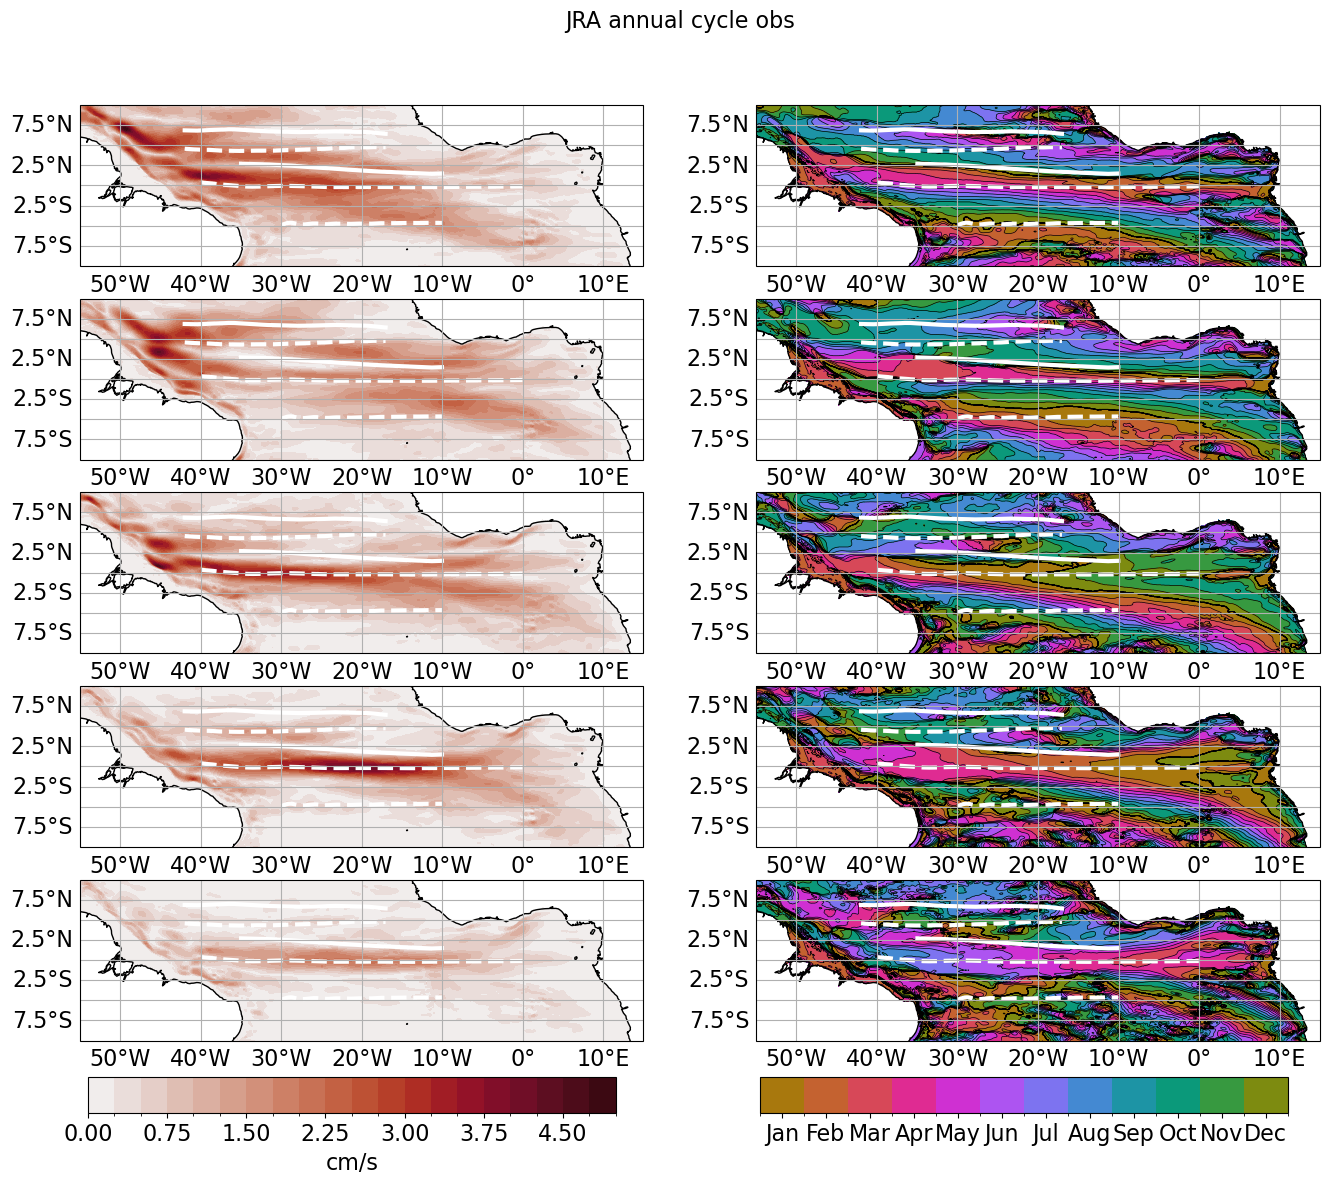

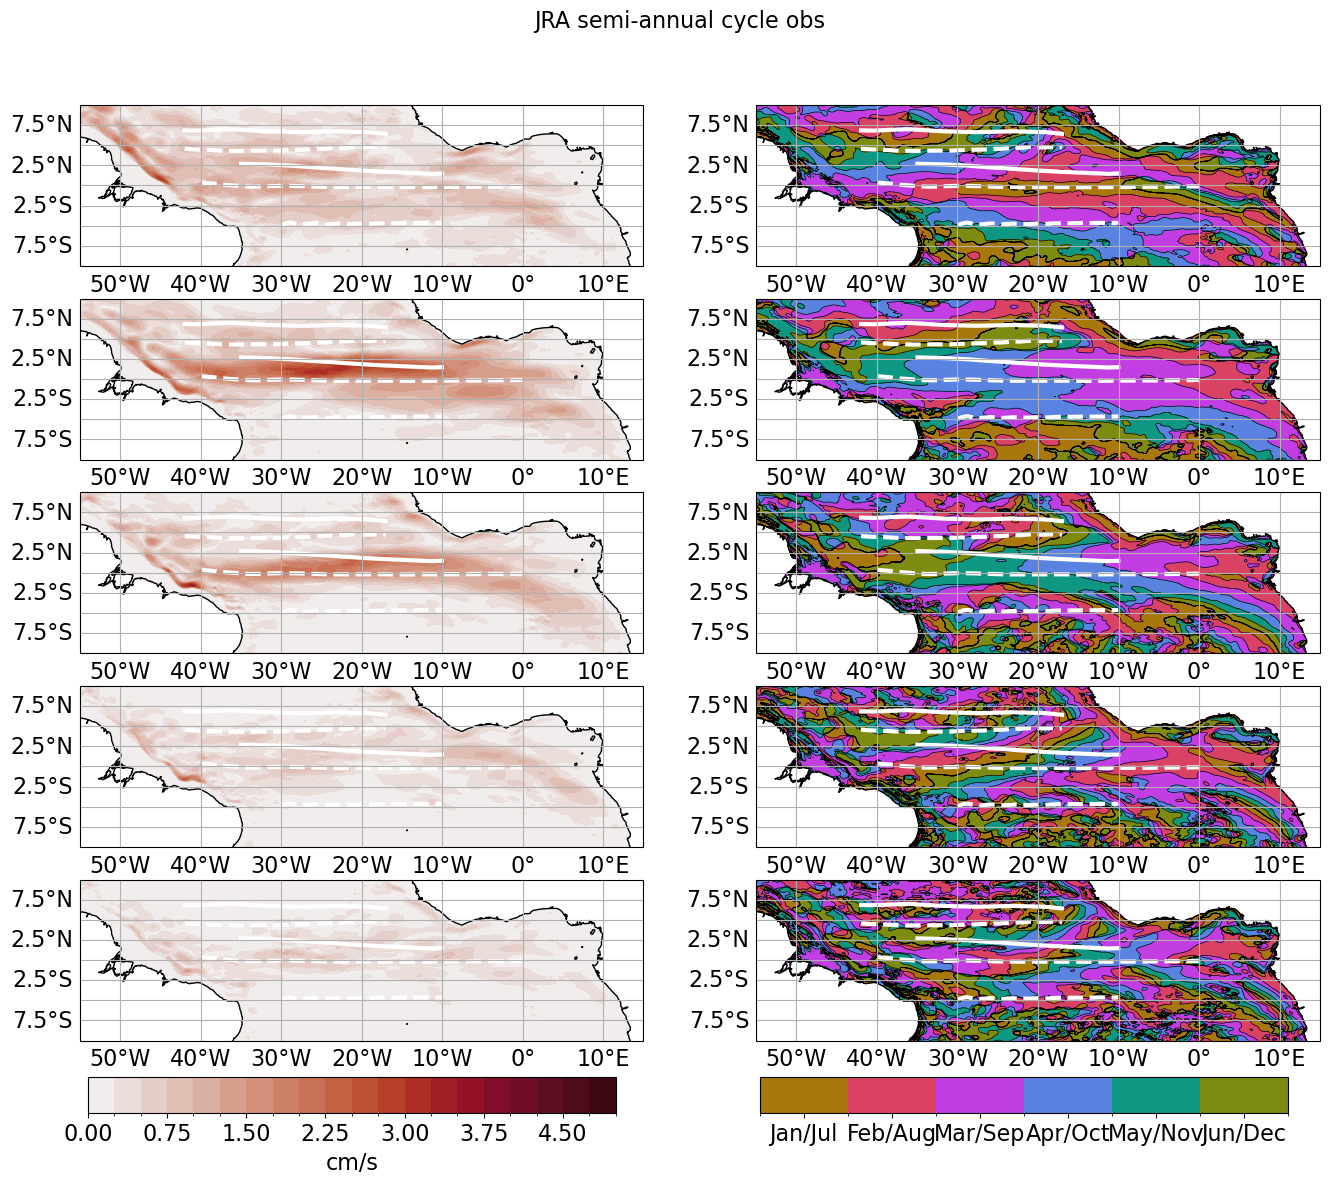

In [26]:
fig_JRA_AH = plot_harmo_allmodes(JRA_rec_AH.idxmax('time'),'ah', JRA_rec_AH.max('time'),'JRA annual cycle obs',
                                 EUC_JRA,NEUC_JRA,SEUC_JRA,NECC_JRA,nSECu_JRA)
fig_JRA_SH = plot_harmo_allmodes(JRA_rec_SH.idxmax('time'),'sah', JRA_rec_SH.max('time'),'JRA semi-annual cycle obs',
                                 EUC_JRA,NEUC_JRA,SEUC_JRA,NECC_JRA,nSECu_JRA)

if savefig:
    fig_JRA_AH.savefig(f'{out_dir_fig}{fig_name_JRA_AH}_{tlim_JRA[0]}_{tlim_JRA[1]}{fig_format}',dpi=300,bbox_inches='tight')
    fig_JRA_SH.savefig(f'{out_dir_fig}{fig_name_JRA_SH}_{tlim_JRA[0]}_{tlim_JRA[1]}{fig_format}',dpi=300,bbox_inches='tight')

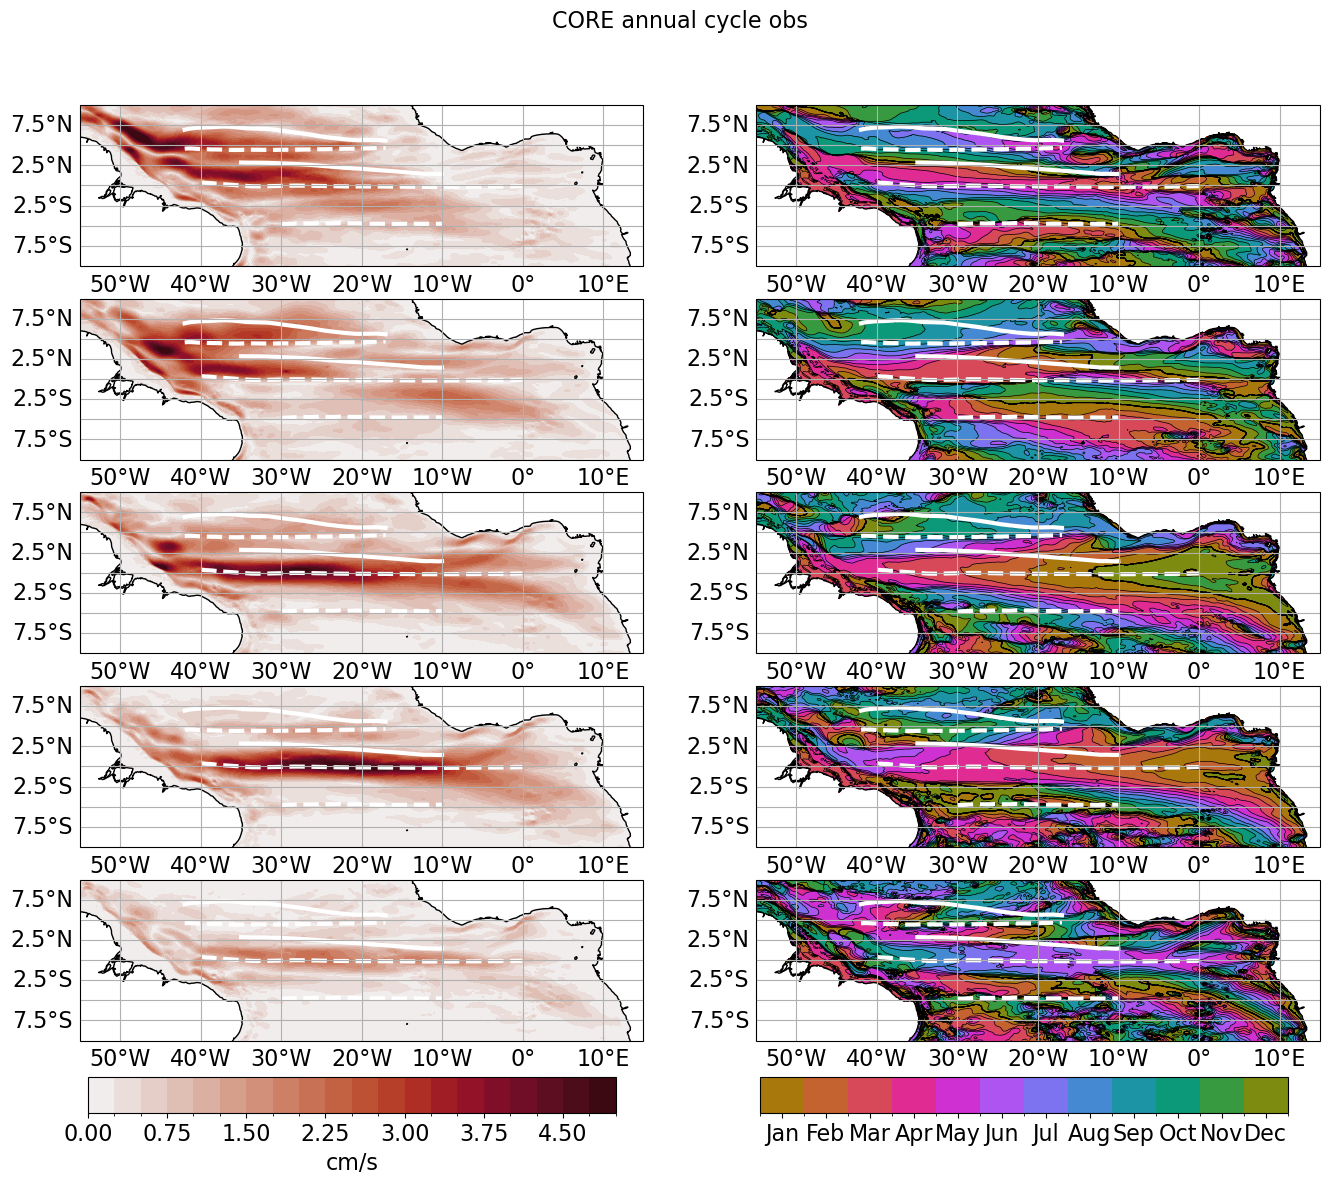

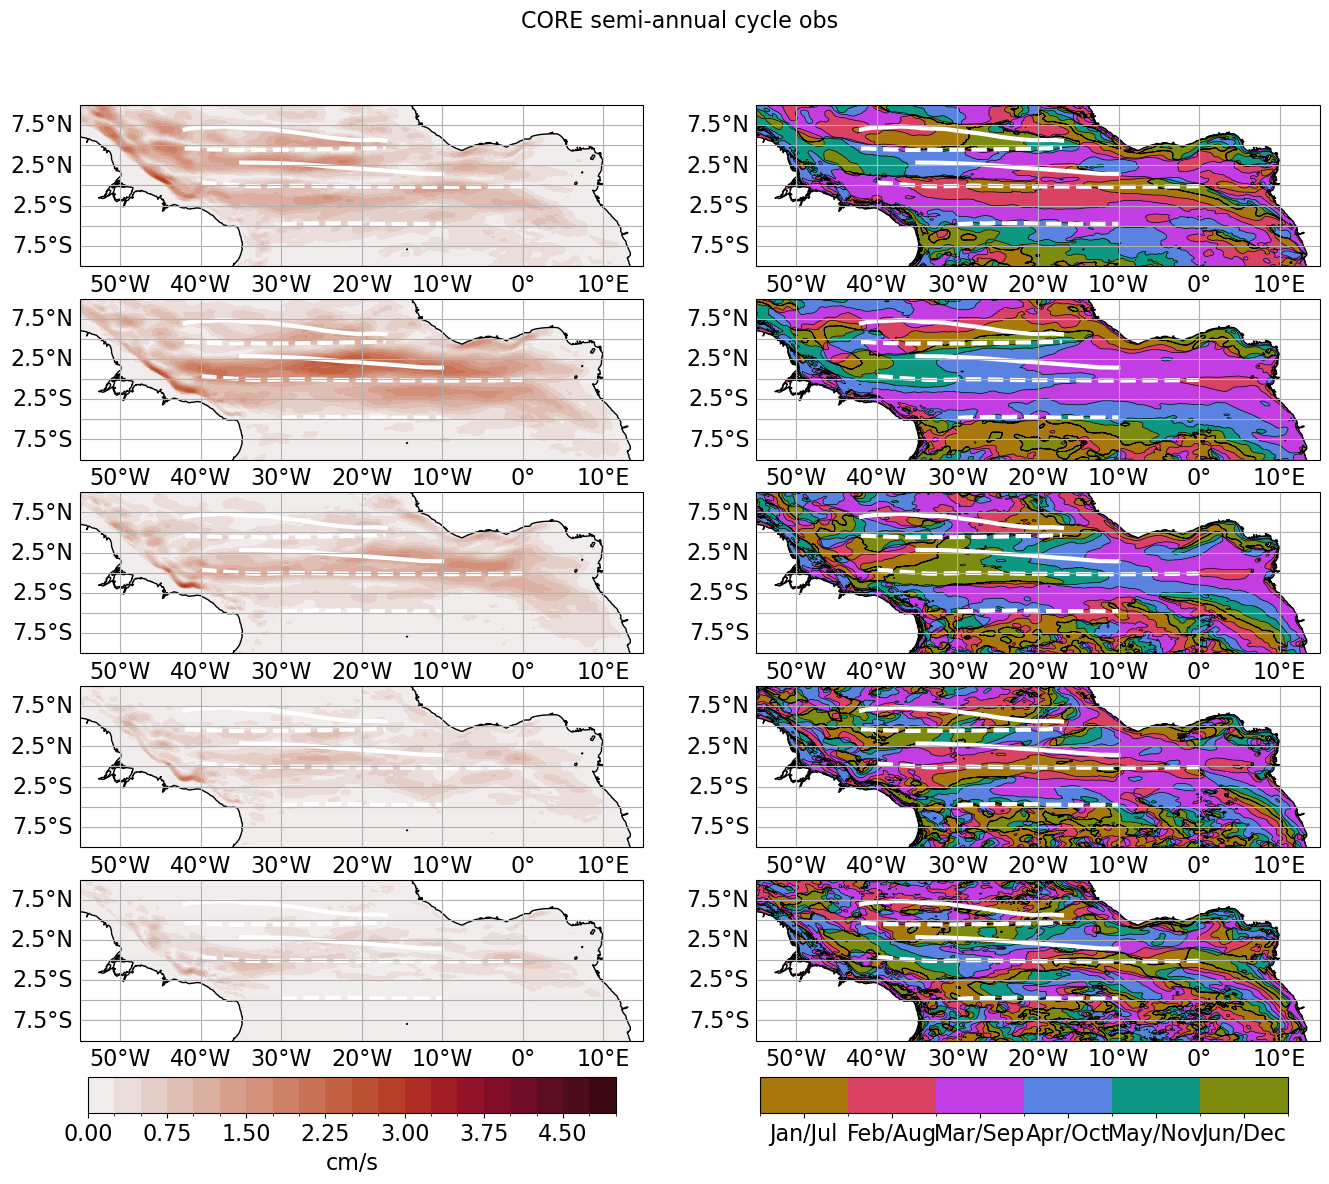

In [27]:
fig_CORE_AH = plot_harmo_allmodes(CORE_rec_AH.idxmax('time'),'ah', CORE_rec_AH.max('time'),'CORE annual cycle obs',
                                  EUC_CORE,NEUC_CORE,SEUC_CORE,NECC_CORE,nSECu_CORE)
fig_CORE_SH = plot_harmo_allmodes(CORE_rec_SH.idxmax('time'),'sah', CORE_rec_SH.max('time'),'CORE semi-annual cycle obs',
                                  EUC_CORE,NEUC_CORE,SEUC_CORE,NECC_CORE,nSECu_CORE)

if savefig:
    fig_CORE_AH.savefig(f'{out_dir_fig}{fig_name_CORE_AH}_{tlim_CORE[0]}_{tlim_CORE[1]}{fig_format}',dpi=300,bbox_inches='tight')
    fig_CORE_SH.savefig(f'{out_dir_fig}{fig_name_CORE_SH}_{tlim_CORE[0]}_{tlim_CORE[1]}{fig_format}',dpi=300,bbox_inches='tight')

In [28]:
# plot functions
def plot_harmo_diff(amp_AH,amp_SH,EUC,NEUC,SEUC,NECC,nSECu):
    map_proj = ccrs.crs.PlateCarree()
    lw=3    
      
    fig, axs = plt.subplots(len(amp_AH.mode),2,figsize=(16,12/5*len(amp_AH.mode)),
                                      subplot_kw = {'projection':map_proj})
    for i,mode in enumerate(amp_AH.mode):
        im_amp = (amp_AH*100).sel(mode=mode).plot.contourf(transform=ccrs.crs.PlateCarree(),ax=axs[i,0],
                                      x='glamu',y='gphiu',                                      
                                      vmax=5,vmin=0,cmap=co.cm.amp,levels=21,
                                      add_colorbar=False)
        EUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        SEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NECC.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        nSECu.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,0],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        

    for i,mode in enumerate(amp_SH.mode):
        im_SH = (amp_SH*100).sel(mode=mode).plot.contourf(transform=ccrs.crs.PlateCarree(),ax=axs[i,1],
                                      x='glamu',y='gphiu',                                      
                                      vmax=5,vmin=0,cmap=co.cm.amp,levels=21,
                                      add_colorbar=False)
        EUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        SEUC.Y_CM.mean(dim=['time_counter']
            ).plot.line('--w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        NECC.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
        nSECu.Y_CM.mean(dim=['time_counter']
            ).plot.line('-w',ax=axs[i,1],transform=ccrs.crs.PlateCarree(),linewidth=lw)
    
    
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.13, 0.04, 0.33, 0.03])
    fig.colorbar(im_amp, cax=cbar_ax, orientation = 'horizontal',label='CORE-JRA AH cm/s')
    
    
    cbar_ax = fig.add_axes([0.55, 0.04, 0.33, 0.03])
    fig.colorbar(im_SH, cax=cbar_ax, orientation = 'horizontal',label='CORE-JRA SH cm/s')
    
    for ax in axs.flat:
        ax.coastlines()
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
    return fig

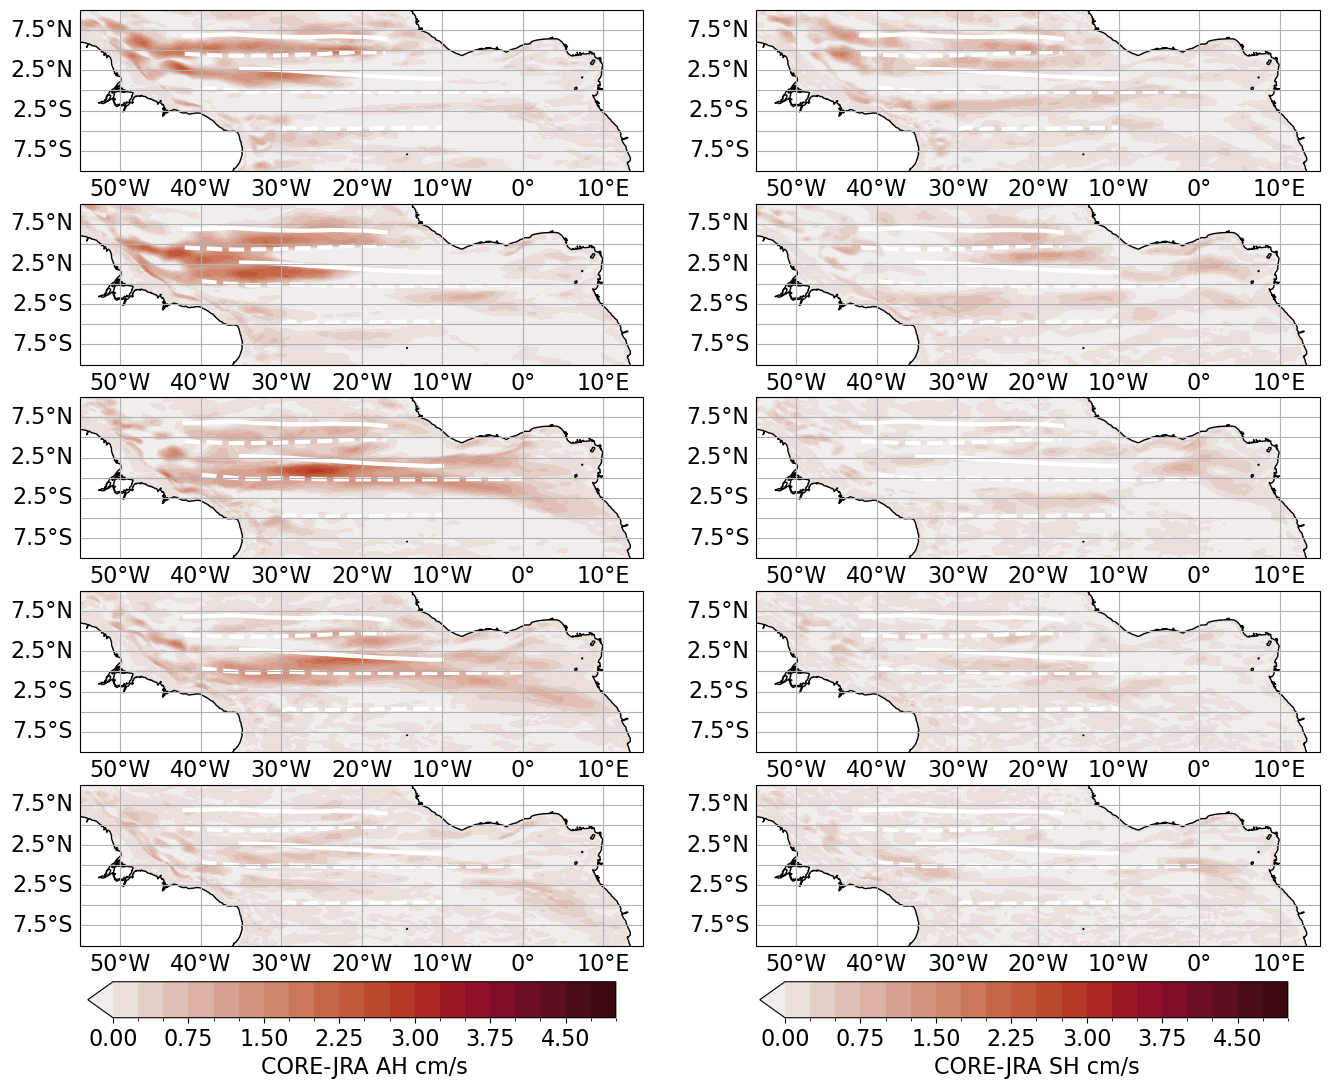

In [29]:
amp_AH = CORE_rec_AH.max('time')-JRA_rec_AH.max('time')
amp_SH = CORE_rec_SH.max('time') - JRA_rec_SH.max('time')
fig_CORE_minus_JRA_AH = plot_harmo_diff(amp_AH,amp_SH,
                                        EUC_JRA,NEUC_JRA,SEUC_JRA,NECC_JRA,nSECu_JRA)

if savefig:
    fig_CORE_minus_JRA_AH.savefig(f'{out_dir_fig}{fig_name_COREminusJRA}_{tlim_CORE[0]}_{tlim_CORE[1]}{fig_format}',dpi=300,bbox_inches='tight')

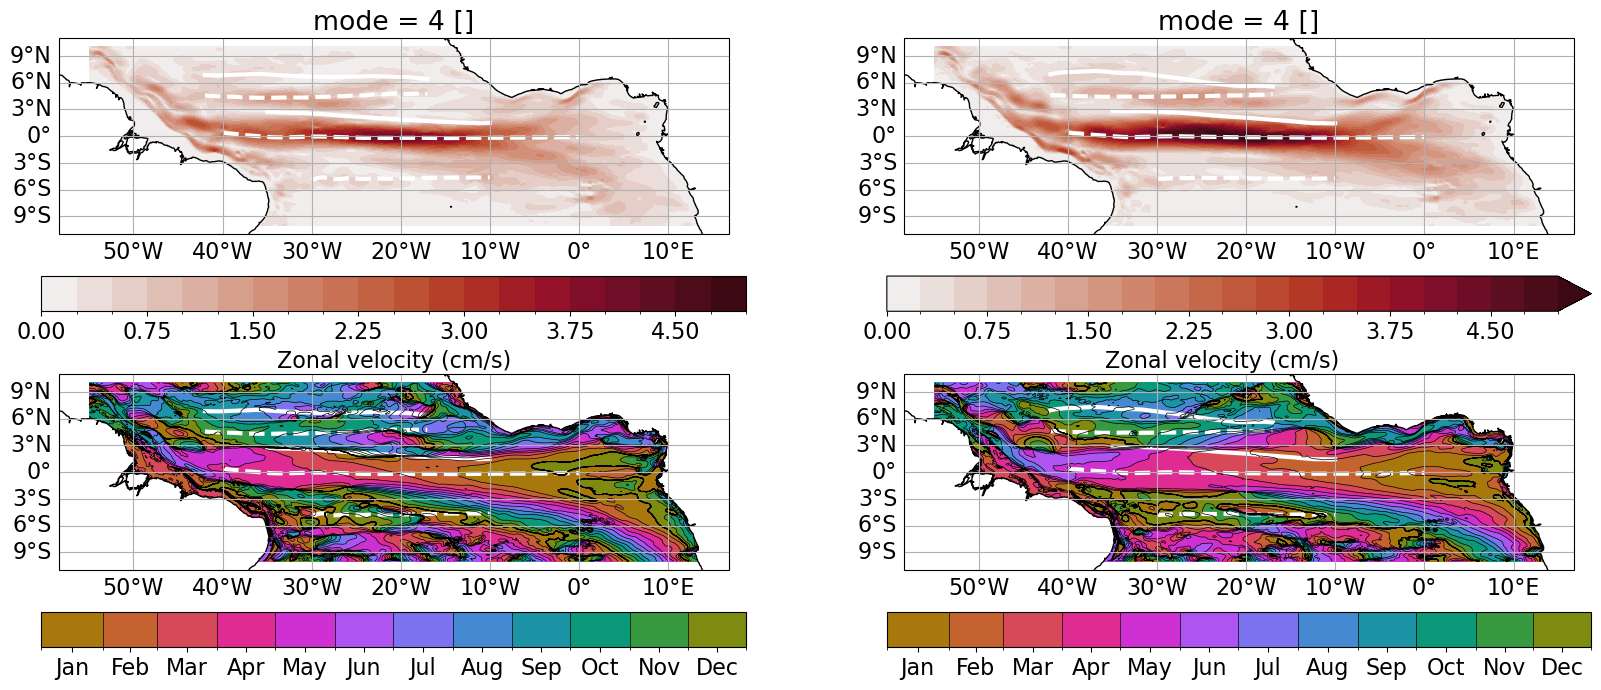

In [30]:
cb_lev = np.array([0,32,60,91,121,152,182,213,244,274,305,335,365])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
lw=3
md = 4

cmap = co.cm.phase
newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)

ds = JRA_rec_AH.sel(mode=md)

data_crs = ccrs.crs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

#JRA
EUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[0,0],linewidth=lw)
NEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[0,0],linewidth=lw)
SEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[0,0],linewidth=lw)
NECC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[0,0],linewidth=lw)
nSECu_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[0,0],linewidth=lw)

(ds.max('time')*100).plot.contourf(transform=data_crs,ax=axes[0,0],
                      x='glamu',y='gphiu',                                      
                      cmap=co.cm.amp,levels=21,vmax=5,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal velocity (cm/s)'})

EUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',ax=axes[1,0],transform=data_crs,linewidth=lw)
NEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',ax=axes[1,0],transform=data_crs,linewidth=lw)
SEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',ax=axes[1,0],transform=data_crs,linewidth=lw)
NECC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',ax=axes[1,0],transform=data_crs,linewidth=lw)
nSECu_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',ax=axes[1,0],transform=data_crs,linewidth=lw)

gm = ds.idxmax('time').plot.contourf(ax=axes[1,0],transform=data_crs,
                      x='glamu',y='gphiu',
                      cmap=newcmap, levels=cb_lev,
                      cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').plot.contour(ax=axes[1,0],
                      x='glamu',y='gphiu',
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)



#CORE
EUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[0,1],transform=data_crs,linewidth=lw)
NEUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[0,1],transform=data_crs,linewidth=lw)
SEUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[0,1],transform=data_crs,linewidth=lw)
NECC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('-w',ax=axes[0,1],transform=data_crs,linewidth=lw)
nSECu_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('-w',ax=axes[0,1],transform=data_crs,linewidth=lw)

ds = CORE_rec_AH.sel(mode=md)
(ds.max('time')*100).plot.contourf(transform=data_crs,ax=axes[0,1],
                      x='glamu',y='gphiu',                                      
                      vmax=5,vmin=0,cmap=co.cm.amp,levels=21,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal velocity (cm/s)'})

EUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[1,1],transform=data_crs,linewidth=lw)
NEUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[1,1],transform=data_crs,linewidth=lw)
SEUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[1,1],transform=data_crs,linewidth=lw)
NECC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('-w',ax=axes[1,1],transform=data_crs,linewidth=lw)
nSECu_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('-w',ax=axes[1,1],transform=data_crs,linewidth=lw)
# nSECl_CORE.Y_CM.mean(dim=['time_counter']
#     ).plot.line('--b',ax=axes[1,1],transform=data_crs,linewidth=lw)

gm = ds.idxmax('time').plot.contourf(ax=axes[1,1],
                      x='glamu',y='gphiu',
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').plot.contour(ax=axes[1,1],
                      x='glamu',y='gphiu',
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)


for i,ax in enumerate(axes.flat):
#     ax.axes.axis('tight')
    ax.coastlines()
    gl = ax.gridlines(crs=data_crs, draw_labels=True,)
    gl.top_labels = gl.right_labels = False

axes[1,0].set_title('')
axes[1,1].set_title('')

if savefig:
    plt.savefig(f'{out_dir_fig}INALT20_AH_mod4_CORE_{tlim_CORE[0]}_{tlim_CORE[1]}_JRA_{tlim_JRA[0]}_{tlim_JRA[1]}{fig_format}',dpi=300,bbox_inches='tight')

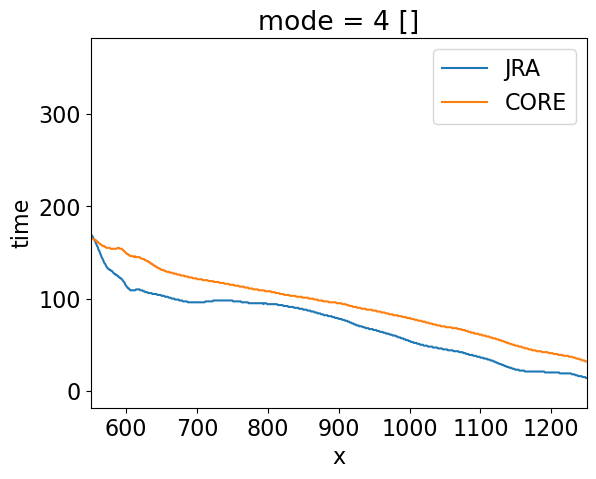

In [36]:
ds1 = JRA_rec_AH.sel(mode=4)
ds1.isel(y=slice(190,210)).mean('y').idxmax('time').plot(x='x',xlim=[550,1250],label='JRA')
ds = CORE_rec_AH.sel(mode=4)
ds.isel(y=slice(190,210)).mean('y').idxmax('time').plot(x='x',xlim=[550,1250],label='CORE')
plt.legend()

In [38]:
print(ds1.sel(x=640).isel(y=slice(190,210)).mean('y').idxmax('time').values-ds.sel(x=640).isel(y=slice(190,210)).mean('y').idxmax('time').values)

-31.0


<xarray.DataArray 'time' ()>
array(21.78)
Coordinates:
    mode     int64 4
<xarray.DataArray 'time' ()>
array(22.)
Coordinates:
    mode     int64 4
<xarray.DataArray 'time' ()>
array(5.75128805)
Coordinates:
    mode     int64 4


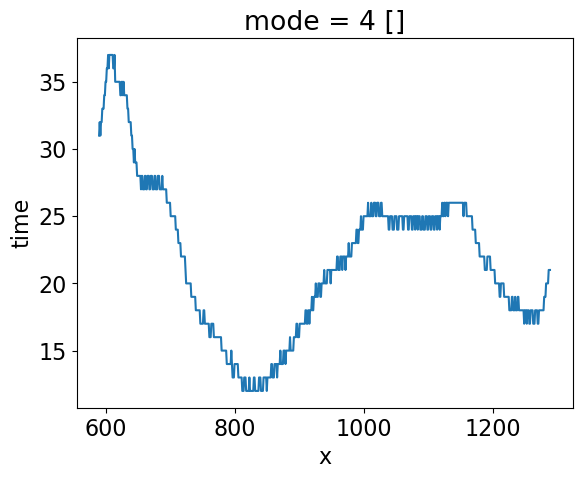

In [33]:
t = ((ds.isel(y=slice(190,210),x=slice(300,1000)).mean('y').idxmax('time')-ds1.isel(y=slice(190,210),x=slice(300,1000)).mean('y').idxmax('time')))
print(np.fabs(t).mean())
print(np.fabs(t).median())
print(np.fabs(t).std())
t.plot()

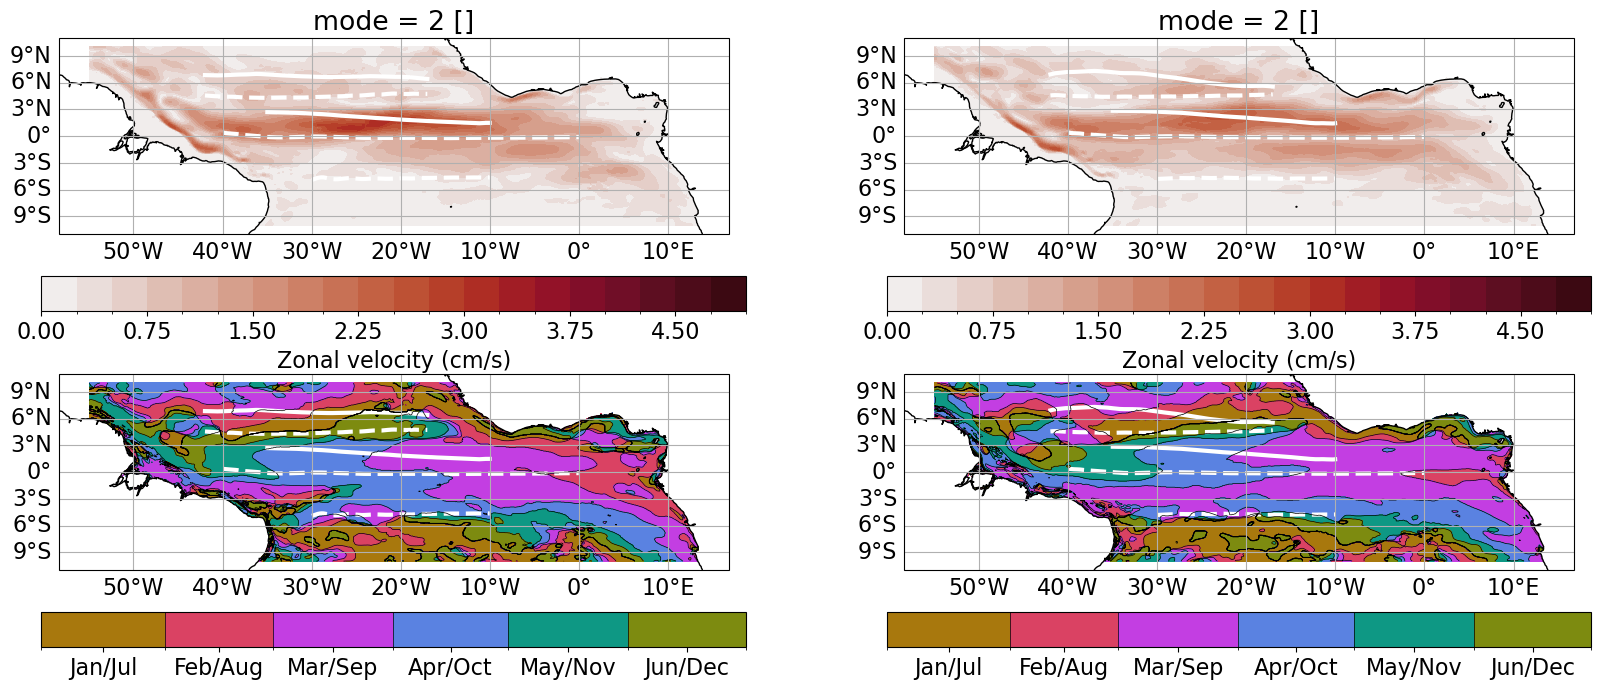

In [34]:
cb_lev = np.array([0,32,60,91,121,152,182.5])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan/Jul','Feb/Aug','Mar/Sep','Apr/Oct','May/Nov','Jun/Dec']
lw=3
md = 2

cmap = co.cm.phase
newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)

ds = JRA_rec_SH.sel(mode=md)

data_crs = ccrs.crs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

#JRA
EUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[0,0],linewidth=lw)
NEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[0,0],linewidth=lw)
SEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[0,0],linewidth=lw)
NECC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[0,0],linewidth=lw)
nSECu_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[0,0],linewidth=lw)

(ds.max('time')*100).plot.contourf(transform=data_crs,ax=axes[0,0],
                      x='glamu',y='gphiu',                                      
                      cmap=co.cm.amp,levels=21,vmax=5,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal velocity (cm/s)'})

EUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',ax=axes[1,0],transform=data_crs,linewidth=lw)
NEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',ax=axes[1,0],transform=data_crs,linewidth=lw)
SEUC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[1,0],linewidth=lw)
NECC_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[1,0],linewidth=lw)
nSECu_JRA.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[1,0],linewidth=lw)

gm = ds.idxmax('time').plot.contourf(ax=axes[1,0],transform=data_crs,
                      x='glamu',y='gphiu',
                      cmap=newcmap, levels=cb_lev,
                      cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').plot.contour(ax=axes[1,0],
                      x='glamu',y='gphiu',
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)



#CORE
ds = CORE_rec_SH.sel(mode=md)

EUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[0,1],transform=data_crs,linewidth=lw)
NEUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[0,1],transform=data_crs,linewidth=lw)
SEUC_CORE.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[0,1],linewidth=lw)
NECC_CORE.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[0,1],linewidth=lw)
nSECu_CORE.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[0,1],linewidth=lw)

(ds.max('time')*100).plot.contourf(transform=data_crs,ax=axes[0,1],
                      x='glamu',y='gphiu',                                      
                      vmax=5,vmin=0,cmap=co.cm.amp,levels=21,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal velocity (cm/s)'})

EUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[1,1],transform=data_crs,linewidth=lw)
NEUC_CORE.Y_CM.mean(dim=['time_counter']
    ).plot.line('--w',ax=axes[1,1],transform=data_crs,linewidth=lw)
SEUC_CORE.Y_CM.mean(dim=['time_counter']
        ).plot.line('--w',transform=data_crs,ax=axes[1,1],linewidth=lw)
NECC_CORE.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[1,1],linewidth=lw)
nSECu_CORE.Y_CM.mean(dim=['time_counter']
        ).plot.line('-w',transform=data_crs,ax=axes[1,1],linewidth=lw)

gm = ds.idxmax('time').plot.contourf(ax=axes[1,1],
                      x='glamu',y='gphiu',
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').plot.contour(ax=axes[1,1],
                      x='glamu',y='gphiu',
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)


for i,ax in enumerate(axes.flat):
#     ax.axes.axis('tight')
    ax.coastlines()
    gl = ax.gridlines(crs=data_crs, draw_labels=True,)
    gl.top_labels = gl.right_labels = False

axes[1,0].set_title('')
axes[1,1].set_title('')
# fig.subplots_adjust(right=0.2)
# cbar_ax = fig.add_axes([0.02, 0.2,.02,.5])
# modes_obs.sel(mode=md).pstruc.plot(y='depth_p',yincrease=False,ax=cbar_ax)
    

if savefig:
    plt.savefig(f'{out_dir_fig}INALT20_SAH_mod2_CORE_{tlim_CORE[0]}_{tlim_CORE[1]}_JRA_{tlim_JRA[0]}_{tlim_JRA[1]}{fig_format}',dpi=300,bbox_inches='tight')

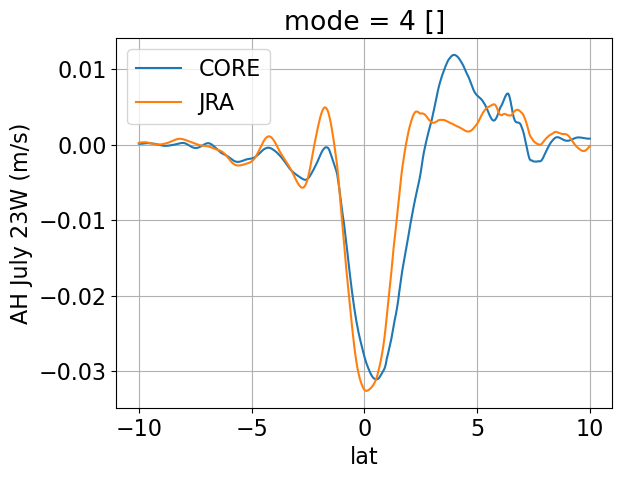

In [35]:
mod=4
ds_JRA = JRA_rec_AH.sel(mode=mod,x=slice(926,930),time=slice(200,230)).mean(['x','time'])
ds_JRA.coords['lat']=JRA_rec_AH.gphiu.sel(x=slice(926,930)).mean('x')
ds_CORE = CORE_rec_AH.sel(mode=mod,x=slice(926,930),time=slice(200,230)).mean(['x','time'])
ds_CORE.coords['lat']=CORE_rec_AH.gphiu.sel(x=slice(926,930)).mean('x')
ds_CORE.plot(x='lat',label='CORE')
ds_JRA.plot(x='lat',label='JRA')
plt.ylabel('AH July 23W (m/s)')
plt.legend()
plt.grid()
if savefig:
    plt.savefig(f'{out_dir_fig}INALT20_AH_mod4_23W_CORE_{tlim_CORE[0]}_{tlim_CORE[1]}_JRA_{tlim_JRA[0]}_{tlim_JRA[1]}{fig_format}',dpi=300)

(-3.0, 3.0)

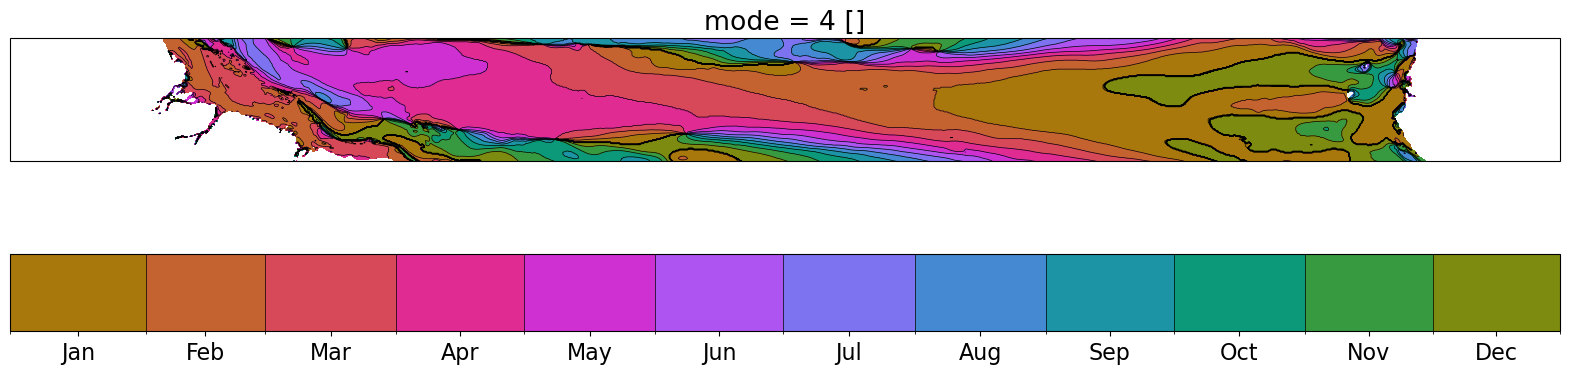

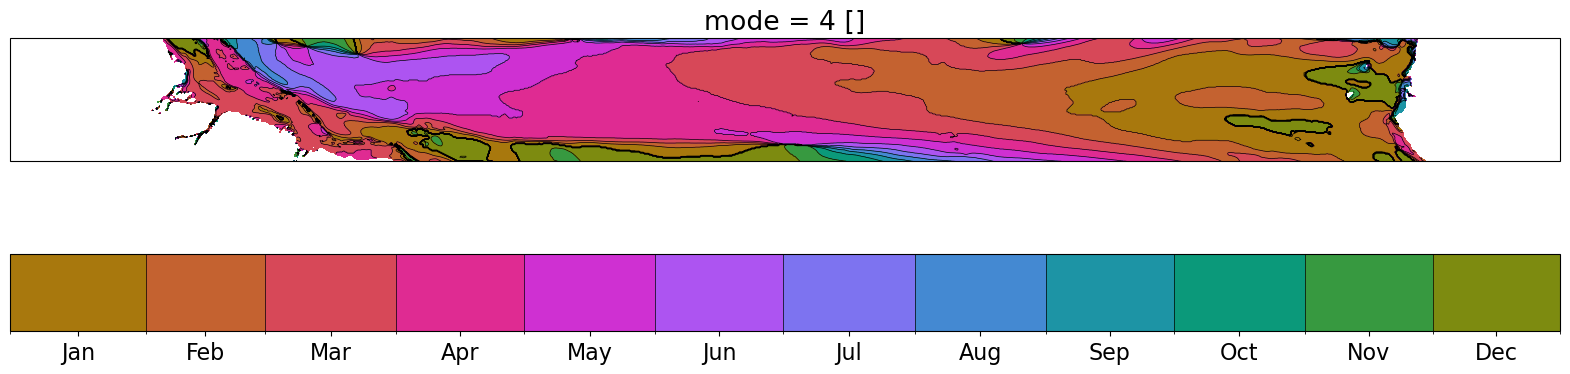

In [36]:
cb_lev = np.array([0,32,60,91,121,152,182,213,244,274,305,335,365])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
lw=3
md = 4

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

ds = JRA_rec_AH.sel(mode=md)
gm = ds.idxmax('time').plot.contourf(ax=axes,
                      x='glamu',y='gphiu',
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').plot.contour(ax=axes,
                      x='glamu',y='gphiu',
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)
plt.grid()
axes.set_ylim([-3,3])

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

ds = CORE_rec_AH.sel(mode=md)
gm = ds.idxmax('time').plot.contourf(ax=axes,
                      x='glamu',y='gphiu',
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').plot.contour(ax=axes,
                      x='glamu',y='gphiu',
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)
plt.grid()
axes.set_ylim([-3,3])